In [10]:
import tensorflow as tf
import time
from tensorflow import keras
import tensorflow.keras.layers as layer
import gym
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorlayer as tl
import torch
import torch.nn as nn
import random

In [11]:
env = gym.make('CartPole-v1')
env.reset()
for _ in range(400):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()


In [12]:
class ReplayBuffer:
    def __init__(self,capacity=10000):
        self.capacity=capacity
        self.buffer=[]
        self.position=0
    
    def push(self,state,action,reward,next_state,done):
        #这里感觉要用capacity来自增会比较好一点
        if len(self.buffer)<self.capacity:
            self.buffer.append(None)
        self.buffer[self.position]=(state,action,reward,next_state,done)
        self.position= int((self.position+1)%self.capacity)
        
    def sample(self,batch_size):
        batch=random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done=map(np.stack,zip(*batch))
        return state,action,reward,next_state,done

In [13]:
class dqn_model(keras.Model):
    def __init__(self,output_shape):
        super(dqn_model,self).__init__()
        self.l1=keras.layers.Dense(32,activation=tf.nn.relu)
        self.l2=keras.layers.Dense(16,activation=tf.nn.relu)
        self.l3=keras.layers.Dense(output_shape)
        
    def call(self,inputs):
        y=self.l1(inputs)
        y=self.l2(y)
        y=self.l3(y)
        return y

In [157]:
class Agent(object):
    def __init__(self,env,lr=0.01,e_greed=0.1,batch_size=40):
        self.batch_size=batch_size
        self.env=env
        self.state_dim=self.env.observation_space.shape[0]
        self.action_dim=self.env.action_space.n
#         def create_model(input_shape):
#             input_layer=tl.layers.Input(input_shape)
#             l1=tl.layers.Dense(32,act=tf.nn.relu)(input_layer)
#             l2=tl.layers.Dense(16,act=tf.nn.relu)(l1)
#             output_layer=tl.layers.Dense(self.action_dim)(l2)
#             return tl.models.Model(inputs=input_layer,outputs=output_layer)
        self.predict_model=dqn_model(self.action_dim) # 默认第一维是batch_size
        self.target_model=dqn_model(self.action_dim)
        self.predict_model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.Adam(0.001))
        self.target_model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.Adam(0.001))
#         self.predict_model.train()
#         self.target_model.eval() #只过是个循环再定期更新
        self.gamma=0.9
        self.epsiron=e_greed
        self.lr=lr
        self.buffer=ReplayBuffer()
#         self.pred_optim=self.target_optim=tf.optimizers.Adam(lr)
        
        
    def target_update(self):
        self.target_model.set_weights(self.predict_model.get_weights())
        
    def choose_action(self,state):
        u=np.random.uniform()
        if u<self.epsiron:
            action=np.random.choice(self.action_dim)
        else:
            q_value=self.predict_model.predict(state[np.newaxis,:])[0]
            action= np.argmax(q_value)
        return action
    
    #使用经验回放来进行更新，预测的更新
    def replay(self):
        for _ in range(10):
            state,action,reward,next_state,done=self.buffer.sample(self.batch_size)
            target=self.target_model.predict(state)

            next_target=self.target_model.predict(next_state)
            next_q=tf.reduce_max(next_target,axis=1) ##Q-learning的算法，找到下一阶段q最大的值
            #更新目前的target
            target[range(self.batch_size),action]=(reward+(1-done)*self.gamma*next_q) #如果done为真则结束。target就为reward
            self.predict_model.fit(state,target)
#             with tf.GradientTape() as tape:
#                 q_predict=self.predict_model(state)
#                 loss=tf.losses.mean_squared_error(target, q_predict)
#             grads=tape.gradients(loss,self.predict_model.trainable_weights)
#             self.pred_optim.apply_gradients(zip(grads,self.predict_model.trainable_weights))
    def train(self,train_episode=200):
        total_r=[]
        for epoch in range(train_episode):
            state=self.env.reset().astype(np.float32)
            total_reward,done=0,False
            while not done:
                action=self.choose_action(state)
                next_state,reward,done,_=self.env.step(action)
                self.buffer.push(state,action,reward,next_state,done)
                total_reward+=reward
                state=next_state
            if len(self.buffer.buffer)>self.batch_size:
                self.replay()
                self.target_update()
            print('EP{} EpisodeReward={}'.format(epoch, total_reward))
            total_r.append(total_reward)
        return total_r

In [158]:
env = gym.make("CartPole-v1")

In [159]:
env.observation_space.shape[0]

4

In [160]:
agent=Agent(env)

In [161]:
total_r=agent.train()

2/2 [==============================] - 0s 3ms/step - loss: 0.3607
EP0 EpisodeReward=57.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3790
EP1 EpisodeReward=54.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3264
EP2 EpisodeReward=30.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2977
EP3 EpisodeReward=41.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2415
EP4 EpisodeReward=29.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2240
EP5 EpisodeReward=42.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2154
EP6 EpisodeReward=28.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3303
EP7 EpisodeReward=36.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1922
EP8 EpisodeReward=27.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1707
EP9 EpisodeReward=29.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2900
EP10 EpisodeReward=61.0
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 0.1243
EP12 EpisodeReward=59.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2056
EP13 EpisodeReward=46.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1725
EP14 EpisodeReward=33.0
2/2 [==============================] - 0s 4ms/step - loss: 0.6869
EP15 EpisodeReward=60.0
2/2 [==============================] - 0s 4ms/step - loss: 0.7729
EP16 EpisodeReward=74.0
2/2 [==============================] - 0s 4ms/step - loss: 0.4352
EP17 EpisodeReward=24.0
2/2 [==============================] - 0s 5ms/step - loss: 0.4323
EP18 EpisodeReward=32.0
2/2 [==============================] - 0s 5ms/step - loss: 0.1183
EP19 EpisodeReward=31.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0528
EP20 EpisodeReward=22.0
2/2 [==============================] - 0s 6ms/step - loss: 0.4776
EP21 EpisodeReward=75.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0680
EP22 EpisodeReward=31.0
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 1.1662
EP24 EpisodeReward=28.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0908
EP25 EpisodeReward=38.0
2/2 [==============================] - 0s 5ms/step - loss: 0.3742
EP26 EpisodeReward=65.0
2/2 [==============================] - 0s 3ms/step - loss: 0.3557
EP27 EpisodeReward=41.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1331
EP28 EpisodeReward=31.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3852
EP29 EpisodeReward=39.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3524
EP30 EpisodeReward=26.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3574
EP31 EpisodeReward=37.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1205
EP32 EpisodeReward=24.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0380
EP33 EpisodeReward=34.0
2/2 [==============================] - 0s 4ms/step - loss: 0.6916
EP34 EpisodeReward=35.0
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 0.3461
EP36 EpisodeReward=33.0
2/2 [==============================] - 0s 4ms/step - loss: 0.5875
EP37 EpisodeReward=30.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2959
EP38 EpisodeReward=72.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2286
EP39 EpisodeReward=52.0
2/2 [==============================] - 0s 4ms/step - loss: 1.9016
EP40 EpisodeReward=35.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0350
EP41 EpisodeReward=52.0
2/2 [==============================] - 0s 4ms/step - loss: 0.8206
EP42 EpisodeReward=40.0
2/2 [==============================] - 0s 4ms/step - loss: 0.7444
EP43 EpisodeReward=44.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0341
EP44 EpisodeReward=90.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2495
EP45 EpisodeReward=44.0
2/2 [==============================] - 0s 3ms/step - loss: 0.4191
EP46 EpisodeReward=32.0
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.0235
EP48 EpisodeReward=42.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2320
EP49 EpisodeReward=53.0
2/2 [==============================] - 0s 4ms/step - loss: 1.7586
EP50 EpisodeReward=39.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1732
EP51 EpisodeReward=68.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3683
EP52 EpisodeReward=29.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2355
EP53 EpisodeReward=53.0
2/2 [==============================] - 0s 4ms/step - loss: 0.4294
EP54 EpisodeReward=52.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0460
EP55 EpisodeReward=85.0
2/2 [==============================] - 0s 4ms/step - loss: 0.3767
EP56 EpisodeReward=28.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2944
EP57 EpisodeReward=46.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1416
EP58 EpisodeReward=43.0
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 1.1699
EP60 EpisodeReward=44.0
2/2 [==============================] - 0s 4ms/step - loss: 0.5284
EP61 EpisodeReward=36.0
2/2 [==============================] - 0s 4ms/step - loss: 1.1350
EP62 EpisodeReward=30.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1693
EP63 EpisodeReward=39.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1710
EP64 EpisodeReward=27.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1769
EP65 EpisodeReward=24.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0204
EP66 EpisodeReward=31.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0148
EP67 EpisodeReward=38.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0165
EP68 EpisodeReward=52.0
2/2 [==============================] - 0s 4ms/step - loss: 1.1737
EP69 EpisodeReward=58.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0396
EP70 EpisodeReward=40.0
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.0162
EP72 EpisodeReward=25.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2712
EP73 EpisodeReward=51.0
2/2 [==============================] - 0s 2ms/step - loss: 0.9462
EP74 EpisodeReward=36.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2108
EP75 EpisodeReward=40.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0171
EP76 EpisodeReward=35.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0300
EP77 EpisodeReward=30.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0180
EP78 EpisodeReward=119.0
2/2 [==============================] - 0s 3ms/step - loss: 0.9306
EP79 EpisodeReward=41.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1646
EP80 EpisodeReward=40.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1259
EP81 EpisodeReward=37.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2908
EP82 EpisodeReward=49.0
2/2 [====

2/2 [==============================] - 0s 3ms/step - loss: 0.1653
EP84 EpisodeReward=49.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0159
EP85 EpisodeReward=45.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1302
EP86 EpisodeReward=40.0
2/2 [==============================] - 0s 4ms/step - loss: 0.8465
EP87 EpisodeReward=84.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0275
EP88 EpisodeReward=41.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1502
EP89 EpisodeReward=29.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1402
EP90 EpisodeReward=37.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1204
EP91 EpisodeReward=36.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0131
EP92 EpisodeReward=52.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0290
EP93 EpisodeReward=43.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1878
EP94 EpisodeReward=40.0
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.0925
EP96 EpisodeReward=38.0
2/2 [==============================] - 0s 3ms/step - loss: 1.2853
EP97 EpisodeReward=51.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2620
EP98 EpisodeReward=36.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1133
EP99 EpisodeReward=47.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0085
EP100 EpisodeReward=26.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0322
EP101 EpisodeReward=50.0
2/2 [==============================] - 0s 3ms/step - loss: 1.3034
EP102 EpisodeReward=73.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1368
EP103 EpisodeReward=48.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1919
EP104 EpisodeReward=71.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0229
EP105 EpisodeReward=57.0
2/2 [==============================] - 0s 4ms/step - loss: 0.8880
EP106 EpisodeReward=70.0
2/2

2/2 [==============================] - 0s 4ms/step - loss: 0.1742
EP108 EpisodeReward=43.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1954
EP109 EpisodeReward=86.0
2/2 [==============================] - 0s 4ms/step - loss: 0.1923
EP110 EpisodeReward=47.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0967
EP111 EpisodeReward=78.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0809
EP112 EpisodeReward=86.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0492
EP113 EpisodeReward=69.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0702
EP114 EpisodeReward=27.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0734
EP115 EpisodeReward=64.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2384
EP116 EpisodeReward=72.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2634
EP117 EpisodeReward=106.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2432
EP118 EpisodeReward=122

EP119 EpisodeReward=71.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0234
EP120 EpisodeReward=64.0
2/2 [==============================] - 0s 3ms/step - loss: 0.1146
EP121 EpisodeReward=58.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0220
EP122 EpisodeReward=66.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2162
EP123 EpisodeReward=65.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0686
EP124 EpisodeReward=91.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0743
EP125 EpisodeReward=64.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0935
EP126 EpisodeReward=52.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2603
EP127 EpisodeReward=9.0
2/2 [==============================] - 0s 3ms/step - loss: 1.0700
EP128 EpisodeReward=31.0
2/2 [==============================] - 0s 4ms/step - loss: 0.9805
EP129 EpisodeReward=11.0
2/2 [==============================] - 0s 4ms/step - loss: 0.6144


2/2 [==============================] - 0s 3ms/step - loss: 0.0498
EP131 EpisodeReward=23.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0511
EP132 EpisodeReward=9.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0221
EP133 EpisodeReward=10.0
2/2 [==============================] - 0s 4ms/step - loss: 2.3463
EP134 EpisodeReward=10.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2372
EP135 EpisodeReward=9.0
2/2 [==============================] - 0s 3ms/step - loss: 0.3499
EP136 EpisodeReward=9.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0480
EP137 EpisodeReward=8.0
2/2 [==============================] - 0s 4ms/step - loss: 2.3704
EP138 EpisodeReward=10.0
2/2 [==============================] - 0s 3ms/step - loss: 0.6878
EP139 EpisodeReward=22.0
2/2 [==============================] - 0s 3ms/step - loss: 0.4456
EP140 EpisodeReward=18.0
2/2 [==============================] - 0s 4ms/step - loss: 1.2566
EP141 EpisodeReward=36.0
2/2

2/2 [==============================] - 0s 4ms/step - loss: 0.0582
EP143 EpisodeReward=39.0
2/2 [==============================] - 0s 3ms/step - loss: 0.3175
EP144 EpisodeReward=50.0
2/2 [==============================] - 0s 4ms/step - loss: 0.2816
EP145 EpisodeReward=99.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0512
EP146 EpisodeReward=47.0
2/2 [==============================] - 0s 4ms/step - loss: 2.2116
EP147 EpisodeReward=48.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0625
EP148 EpisodeReward=99.0
2/2 [==============================] - 0s 3ms/step - loss: 0.2898
EP149 EpisodeReward=40.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0502
EP150 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0531
EP151 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0355
EP152 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 1.9544
EP153 EpisodeReward=5

2/2 [==============================] - 0s 3ms/step - loss: 0.0268
EP155 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0408
EP156 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 1.4877
EP157 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.4062
EP158 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0499
EP159 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.4283
EP160 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0436
EP161 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.1475
EP162 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0220
EP163 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 1.2080
EP164 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0316
EP165 EpisodeR

2/2 [==============================] - 0s 4ms/step - loss: 0.0118
EP167 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0343
EP168 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0095
EP169 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0216
EP170 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0087
EP171 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0089
EP172 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0104
EP173 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0130
EP174 EpisodeReward=500.0
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
EP175 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0089
EP176 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0082
EP177 EpisodeR

2/2 [==============================] - 0s 4ms/step - loss: 0.0090
EP179 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0173
EP180 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0048
EP181 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0065
EP182 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0055
EP183 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0054
EP184 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0072
EP185 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0230
EP186 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0061
EP187 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0053
EP188 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0080
EP189 EpisodeR

2/2 [==============================] - 0s 5ms/step - loss: 0.0138
EP191 EpisodeReward=500.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0062
EP192 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0057
EP193 EpisodeReward=500.0
2/2 [==============================] - 0s 6ms/step - loss: 0.0044
EP194 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0045
EP195 EpisodeReward=387.0
2/2 [==============================] - 0s 5ms/step - loss: 0.0055
EP196 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0049
EP197 EpisodeReward=500.0
2/2 [==============================] - 0s 3ms/step - loss: 0.0040
EP198 EpisodeReward=500.0
2/2 [==============================] - 0s 4ms/step - loss: 0.0038
EP199 EpisodeReward=500.0


In [163]:
s = env.reset()
score = 0
for _ in range(1000):
    env.render()
#     time.sleep(0.01)
    a = np.argmax(agent.predict_model.predict(np.array([s]))[0])
    s, reward, done, _ = env.step(a)
    score += reward
    if done:
        print('score:', score)
        break
env.close()

score: 500.0


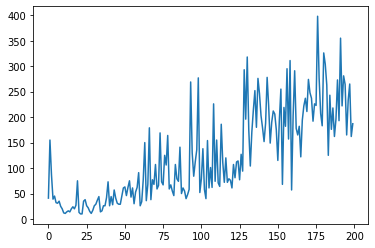

In [155]:
plt.plot(total_r)#target是predict_model.predict

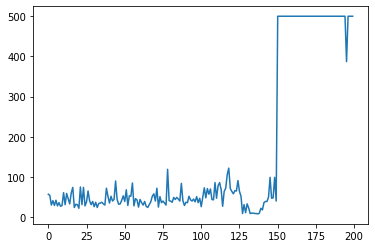

In [162]:
plt.plot(total_r)#target是target_model.predict